In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import pickle
from scipy import stats



# load data

In [3]:
with open('../../data/movies.pkl', 'rb') as file:
    movies = pickle.load(file)


### US selection

In [4]:
# function that extract if movies was created in US

def count_country(data, country = "United States of America"):
    '''
    goal : count if a given country is in the list of countries
    input: the dataset and the country of interest
    output: the number of times a country is the data
    '''
    total = 0
    for j in data:
        if j is not None:
            total += j.count(country)
    return total

# we will apply the function count_country to divide US movies from non us movies
# a US movie is a movie where US appears once

us =  movies["Movie_countries"].apply(lambda x: count_country(x))
us_movies = movies.copy()
us_movies["count_us"] = us

nonus_movies = us_movies.loc[us_movies["count_us"]==0]
us_movies = us_movies.loc[us_movies["count_us"]>0]

len(nonus_movies)


16870

### get list of all genres 

In [5]:
#get the list of genre

genres_unique = []
for j in movies["Movie_genres"]:
    if j is not None:
        for genre in j:
            genres_unique.append(genre)
genres_unique = np.unique(genres_unique)

In [6]:
# list a genre with increase in US movies

movies_before = us_movies.loc[ (us_movies.Movie_release_date.dt.year >1995) &(us_movies.Movie_release_date.dt.year < 2002)]
movies_after = us_movies.loc[ (us_movies.Movie_release_date.dt.year >=2002) &(us_movies.Movie_release_date.dt.year < 2007)]

genre_count_before = [0 for i in range(len(genres_unique))]
genre_count_after = [0 for i in range(len(genres_unique))]

genre_diff = [0 for i in range(len(genres_unique))]

for i in range(len(genres_unique)):
    sum = 0
    for j in movies_after["Movie_genres"]:
        if j is not None:
            sum += j.count(genres_unique[i])
    genre_count_after[i] = sum

    sum = 0
    for j in movies_before["Movie_genres"]:
        if j is not None:
            sum += j.count(genres_unique[i])
    genre_count_before[i] = sum

    if genre_count_before[i] > 0 :
        genre_diff[i] =   (genre_count_after[i] -   genre_count_before[i])



In [7]:
df = pd.DataFrame({
    'genre': genres_unique,
    'count_before': genre_count_before,
    'count_after': genre_count_after,
    'count_diff' :genre_diff
})
df["abs_diff"] = df['count_diff'].apply(lambda x: np.abs(x))

df.sort_values(by ="count_diff", ascending = False).head(50)
genres1 = df.sort_values(by ="count_diff", ascending = False).head(20).genre.values
genres = ["Documentary","Horror","Culture & Society","Biography","Comedy",'Social issues','Slasher',"Political cinema","War film","History"]

In [8]:
#function to count the genre
def count_genre(data, genre):
    '''
    function that countes the occurence of a given genre in the data 
    '''
    total = 0
    for j in data["Movie_genres"]:
        if j is not None:
            total += j.count(genre)
    return total

def plot_percentage_movies_genre(data, genre, year_initial, year_end, focus_year,ax, fig):
    '''
    a function that plot the percentage of a given genre as a function of time
        the percentage is defined as the occurence the given genre divided by the total numbe of genres

    input 
        data: the dataset
        genre: the genre that we docus on
        year_initial: the beginning of the period we focus on 
        year_end: the end of the period we focus on
        focus_year: the year the event we study appears
        ax,fig: used later for subplots
    '''
    genre = genre  

    # count the number of movies that have the given genre per year 
    movies_year = data.groupby(data.Movie_release_date.dt.year).apply(lambda x: count_genre(x, genre)).reset_index()
    movies_year.columns = ["year", "count"]

    # get the total number of genre for a given year, a movies with 5 genres will add 5 to the total count  
    #if we want to divise by the total number of movies, change by sum by count 
    yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum')

    #percentage of a given genre
    percentage = movies_year.loc[(movies_year.year>year_initial) & (movies_year.year<year_end)]["count"]/yearly_movies[(yearly_movies.index >year_initial) & (yearly_movies.index < year_end)].values*100

    #plot
    ax.plot(movies_year.loc[(movies_year.year > year_initial  )&( movies_year.year < year_end)]["year"], percentage, color ='b')
    ax.plot([focus_year,focus_year],[percentage.min(), percentage.max()], color = 'r' )
    ax.set_title(genre)
    ax.tick_params(axis='both', which='major', labelsize=7)
    ax.set_xticks(np.arange(year_initial, year_end, 1))
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
    fig.text(0.04, 0.5, 'percentage of movies from given genre per year', ha='center', rotation='vertical')
    ax.grid()

def plot_percentage_movies_genre_all(data, genres, year_initial, year_end, focus_year,nrows,ncols):
    '''
    a function that wraps up the plots for various genres with a subplor with nrows and ncols 
    
    '''
    fig, axs = plt.subplots(nrows = nrows, ncols = ncols, figsize=(15,25))

    for i in range(nrows):
        for j in range(ncols):
            ax = axs[i][j]
            plot_percentage_movies_genre(movies, genres[i*ncols+j], year_initial, year_end, focus_year, ax, fig)



In [9]:
def get_movies_genre_change(data, genres_unique, nb_genres, year_initial, year_middle, year_end):
    '''
    a function that provides as an output a sorted dataset with a first column genre,
    a second count_before the percentage of occurence of the given genre between year_innitial and year_middle
    a third count_after the percentage of occurence of the given genre between year_middle and year_end
    a last columns with increase/ decrease in the occurence by evaluatinf the difference between the ones before and after divided by the percentage before 
    
    the function also take as input genres_uniques the list of genres in the dataset
    nb_genres  
    '''
    # total number of genres for movies before and after the specified year range
    before_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_before_yearly_movies = before_yearly_movies.loc[
        (before_yearly_movies.Movie_release_date > year_initial) & 
        (before_yearly_movies.Movie_release_date < year_middle)
    ]["nb_genre"].sum()

    after_yearly_movies = data.groupby(data.Movie_release_date.dt.year)['nb_genre'].agg('sum').reset_index()
    sum_after_yearly_movies = after_yearly_movies.loc[
        (after_yearly_movies.Movie_release_date >= year_middle) & 
        (after_yearly_movies.Movie_release_date < year_end)
    ]["nb_genre"].sum()

    movies_before = data.loc[
        (data.Movie_release_date.dt.year > year_initial) & 
        (data.Movie_release_date.dt.year < year_middle)
    ]
    movies_after = data.loc[
        (data.Movie_release_date.dt.year >= year_middle) & 
        (data.Movie_release_date.dt.year < year_end)
    ]


    genre_count_before = [0 for _ in range(len(genres_unique))]
    genre_count_after = [0 for _ in range(len(genres_unique))]
    genre_count_diff = [0 for _ in range(len(genres_unique))]

    # Calculate the percentage of each genre before and after the
    for i in range(len(genres_unique)):
        sum = 0
        for j in movies_after["Movie_genres"]:
            if j is not None:
                sum += j.count(genres_unique[i])
        genre_count_after[i] = sum / sum_after_yearly_movies * 100

        sum= 0
        for j in movies_before["Movie_genres"]:
            if j is not None:
                sum += j.count(genres_unique[i])
        genre_count_before[i] = sum  / sum_before_yearly_movies * 100
        if genre_count_before[i] != 0:
            genre_count_diff[i] =  (genre_count_after[i] -   genre_count_before[i])/genre_count_before[i]
        else :
             genre_count_diff[i] = 0

    
    df = pd.DataFrame({
        'genre': genres_unique,
        'count_before': genre_count_before,
        'count_after': genre_count_after,
        'count_diff': genre_count_diff
    })
    df["abs_diff"] = df['count_diff'].apply(lambda x: np.abs(x))

    # top genres based on `count_diff`
    df = df.sort_values(by="abs_diff", ascending=False).head(nb_genres)
    genres = df['genre'].values  

    return df

def plot_movies_genre_change(df):
        '''
        a function that plots a barplots for before and after the middleyear 
        '''
        fig, ax = plt.subplots(figsize=(15, 8))
        width = 0.35
        x = np.arange(len(df.genre))  # 

        bars_before = ax.bar(x - width/2, df['count_before'], width, label='Before Event', color='blue')
        bars_after = ax.bar(x + width/2, df['count_after'], width, label='After Event', color='orange')

        ax.set_xticks(x)
        ax.set_xticklabels(df.genre, rotation=90)  
        ax.set_title("Genre distribution before and after event")
        ax.set_ylabel("Percentage (%)")
        ax.set_yscale("log")  
        ax.legend()

        plt.tight_layout()
        plt.show()

    



### Second world war

In [10]:

df = get_movies_genre_change(us_movies, genres_unique, -1, 1934,  1940,1946)
t_statistic, p_value = stats.ttest_ind(df.count_before, df.count_after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

t-statistic: 0.001818411902603657
p-value: 0.9985496259412436


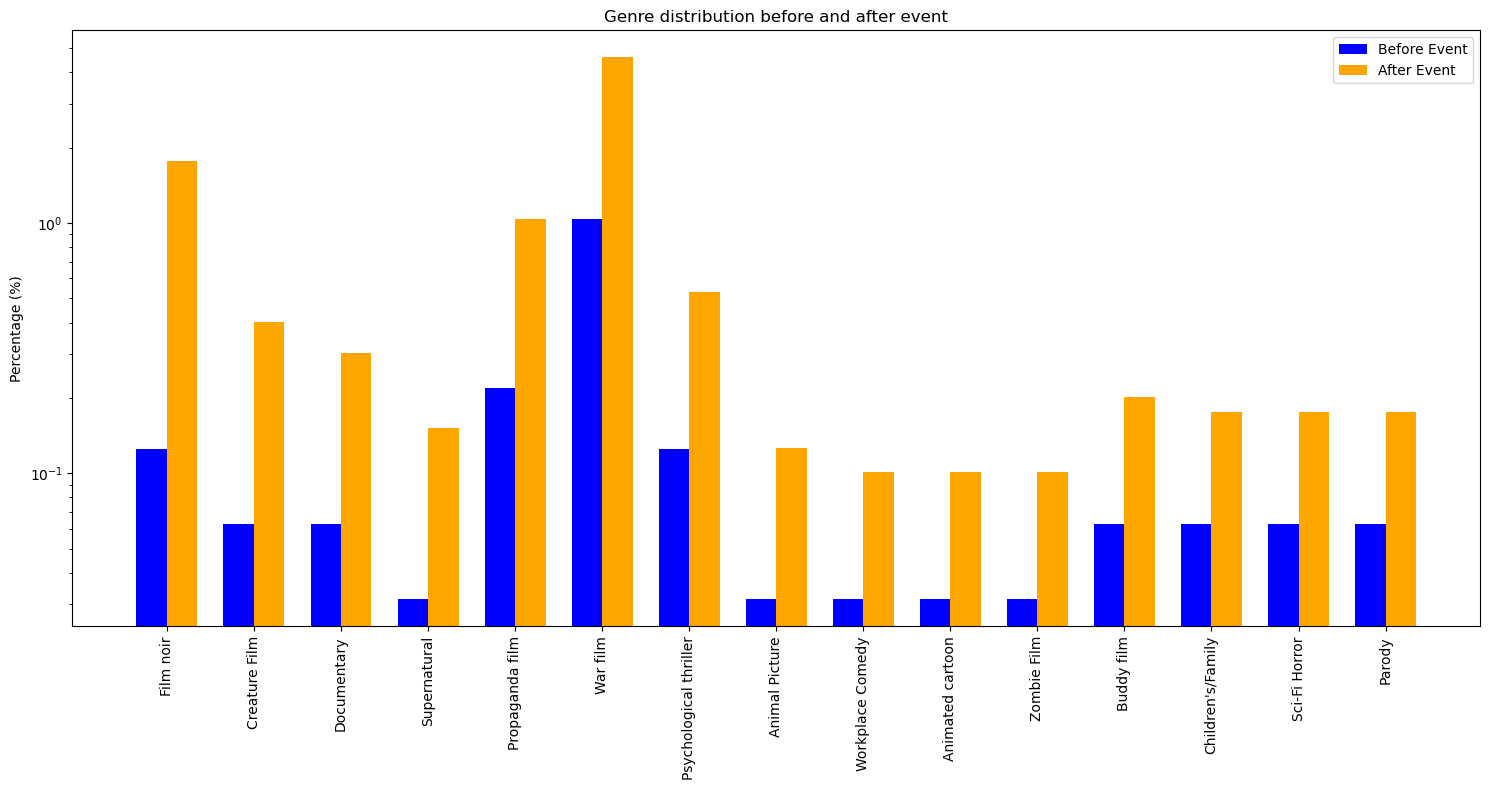

t-statistic: -1.6923928763796547
p-value: 0.10167168746049712


In [11]:

df = get_movies_genre_change(movies, genres_unique, 15, 1934,  1940,1946)
plot_movies_genre_change(df)
t_statistic, p_value = stats.ttest_ind(df.count_before, df.count_after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

f we focus on the 20 genres with the highest change before and after 1940 for movies produced between 1934–1940 and 1940–1946, there is a shift in the distribution of movies. The genres concerned include, for example, war films and propaganda movies. the shift is not statistically significant

However, if we consider all genres, the difference is less important.

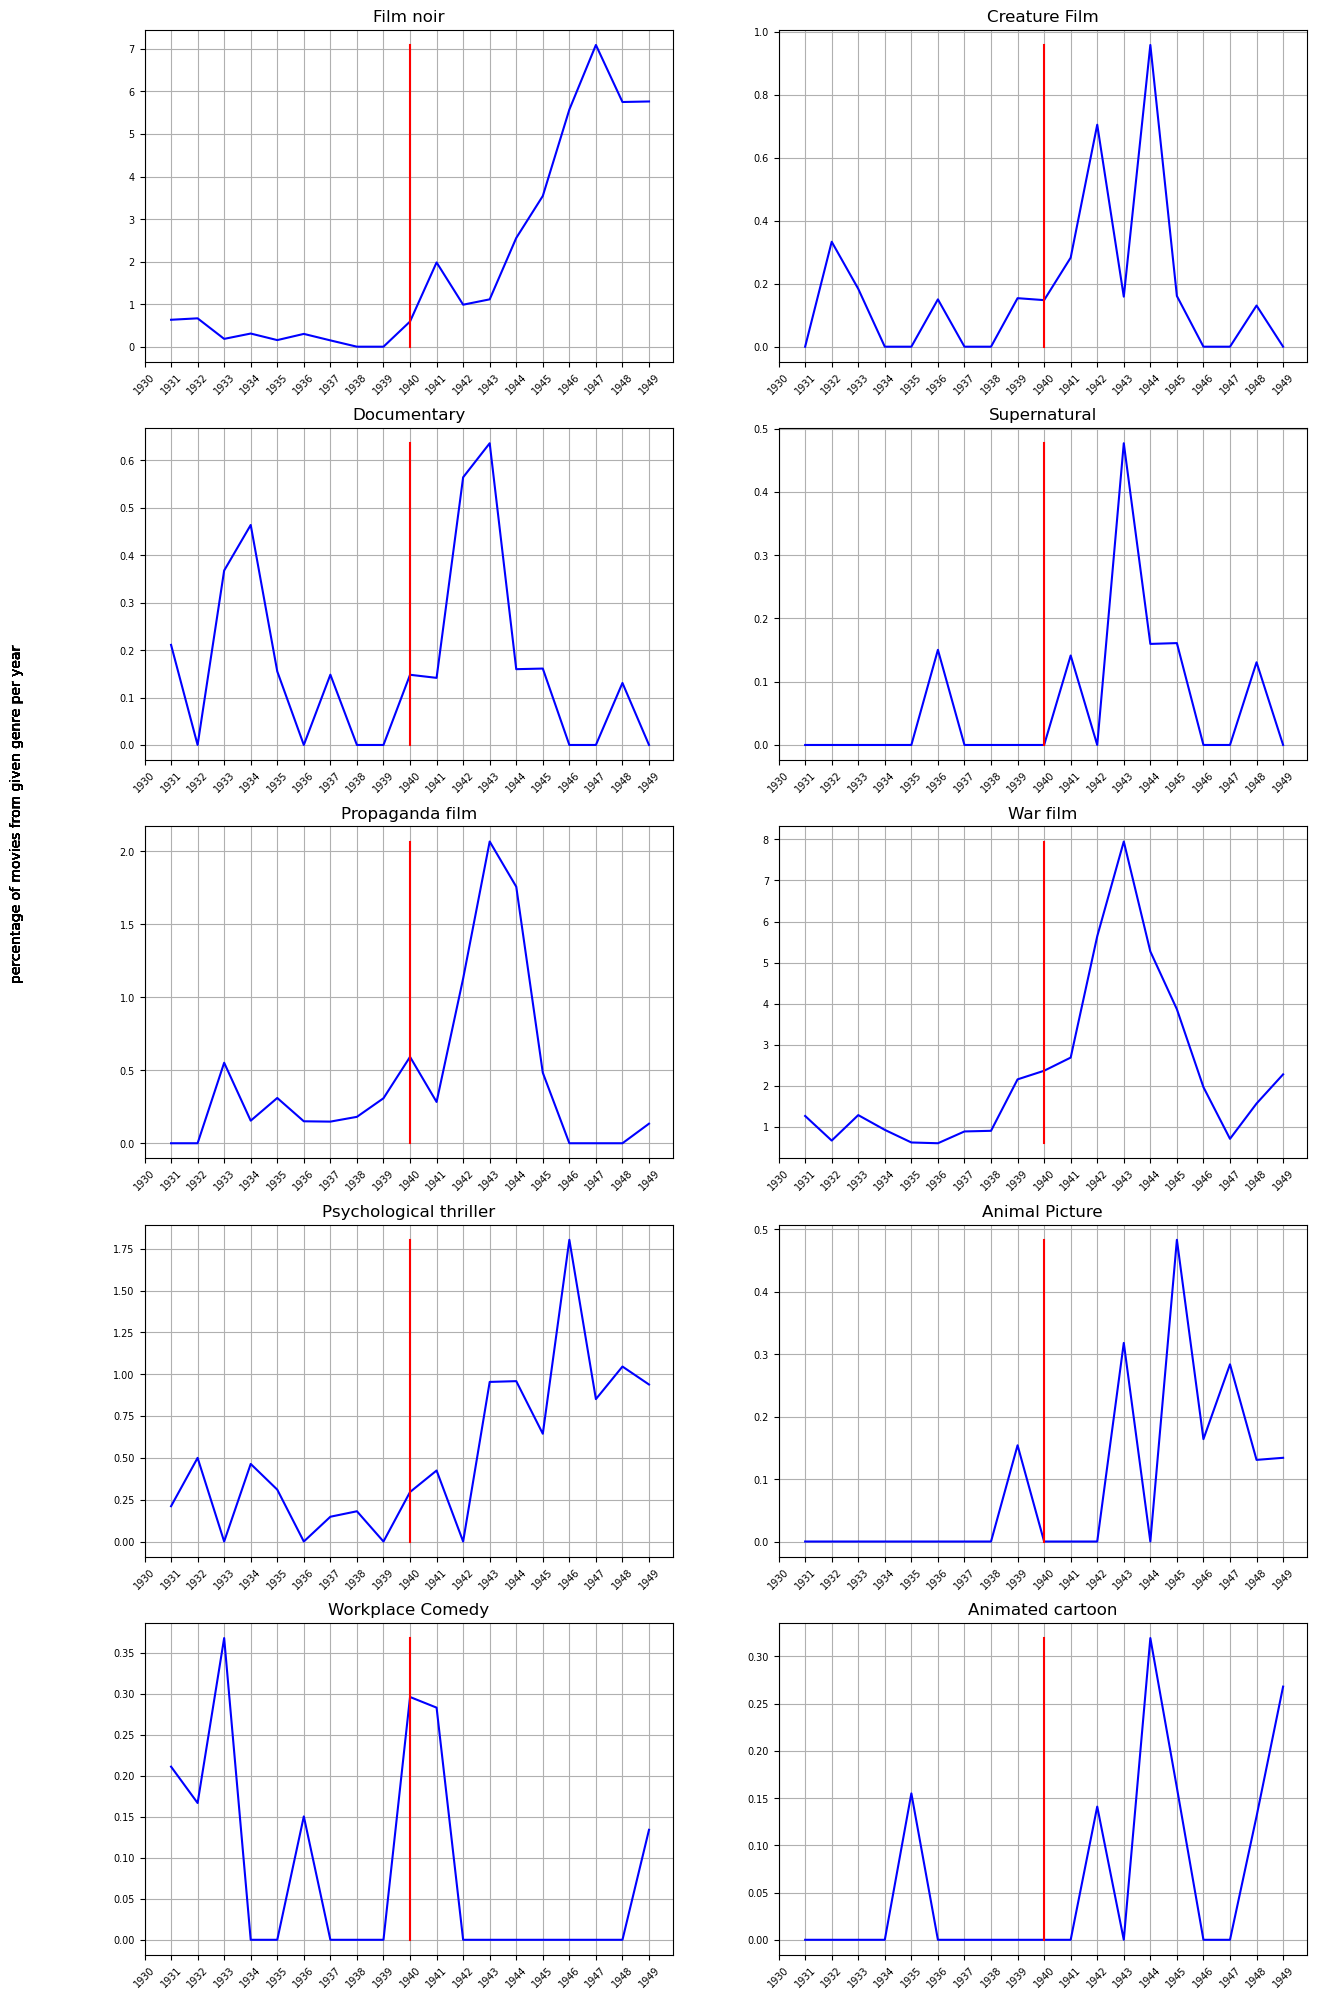

In [12]:
#focus on some specific genres
df = get_movies_genre_change(movies, genres_unique, 10, 1934,  1940,1946)
plot_percentage_movies_genre_all(movies,df.genre.values,1930, 1950, 1940,5,2)

# 9/11

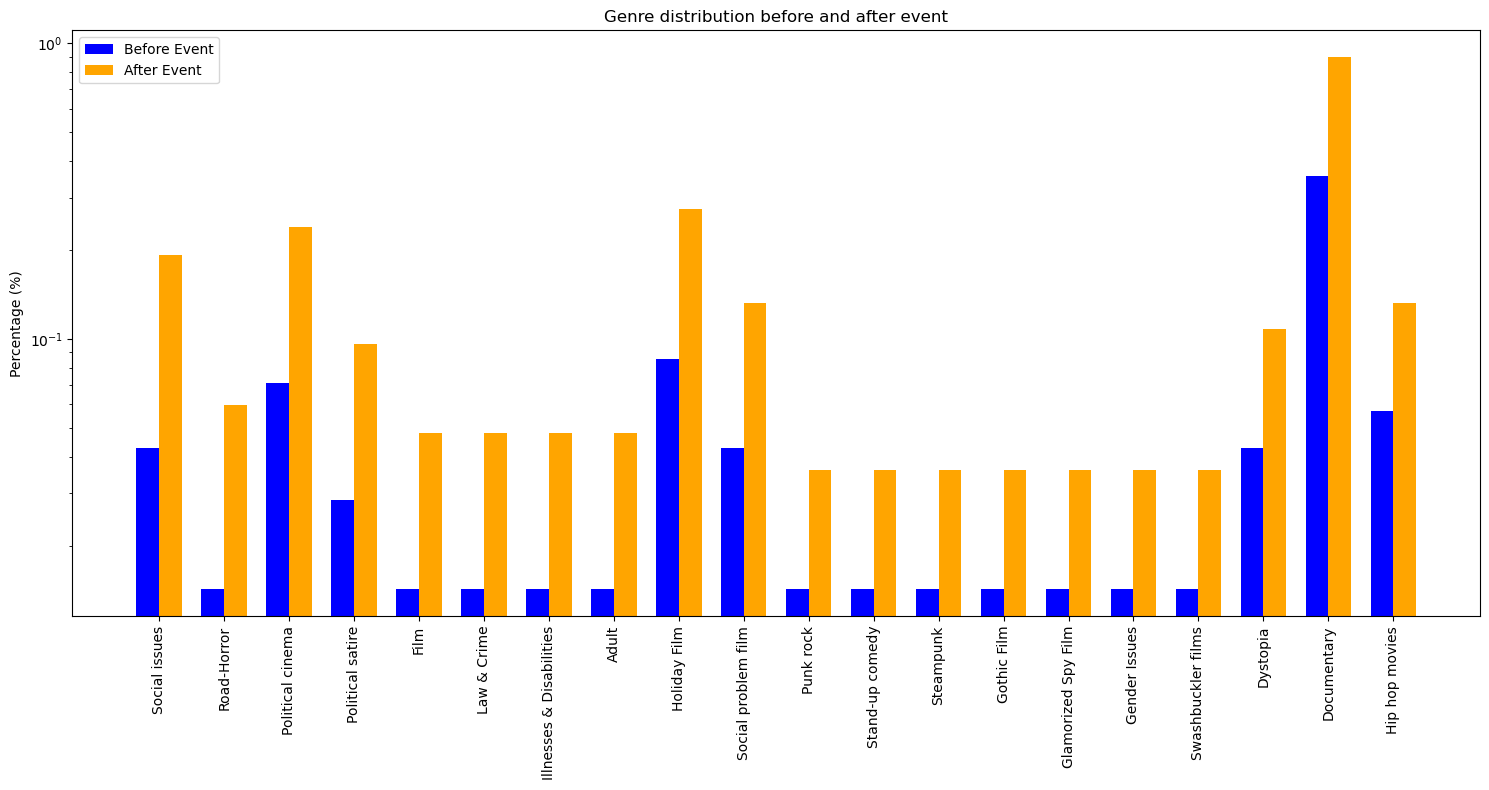

t-statistic: -1.7938977578733226
p-value: 0.08078973017278285


In [13]:
df = get_movies_genre_change(us_movies, genres_unique, 20, 1997,  2002,2006)
plot_movies_genre_change(df)
t_statistic, p_value = stats.ttest_ind(df.count_before, df.count_after)

print("t-statistic:", t_statistic)
print("p-value:", p_value)

The genres with the highest change are social issues, horror, political cinema

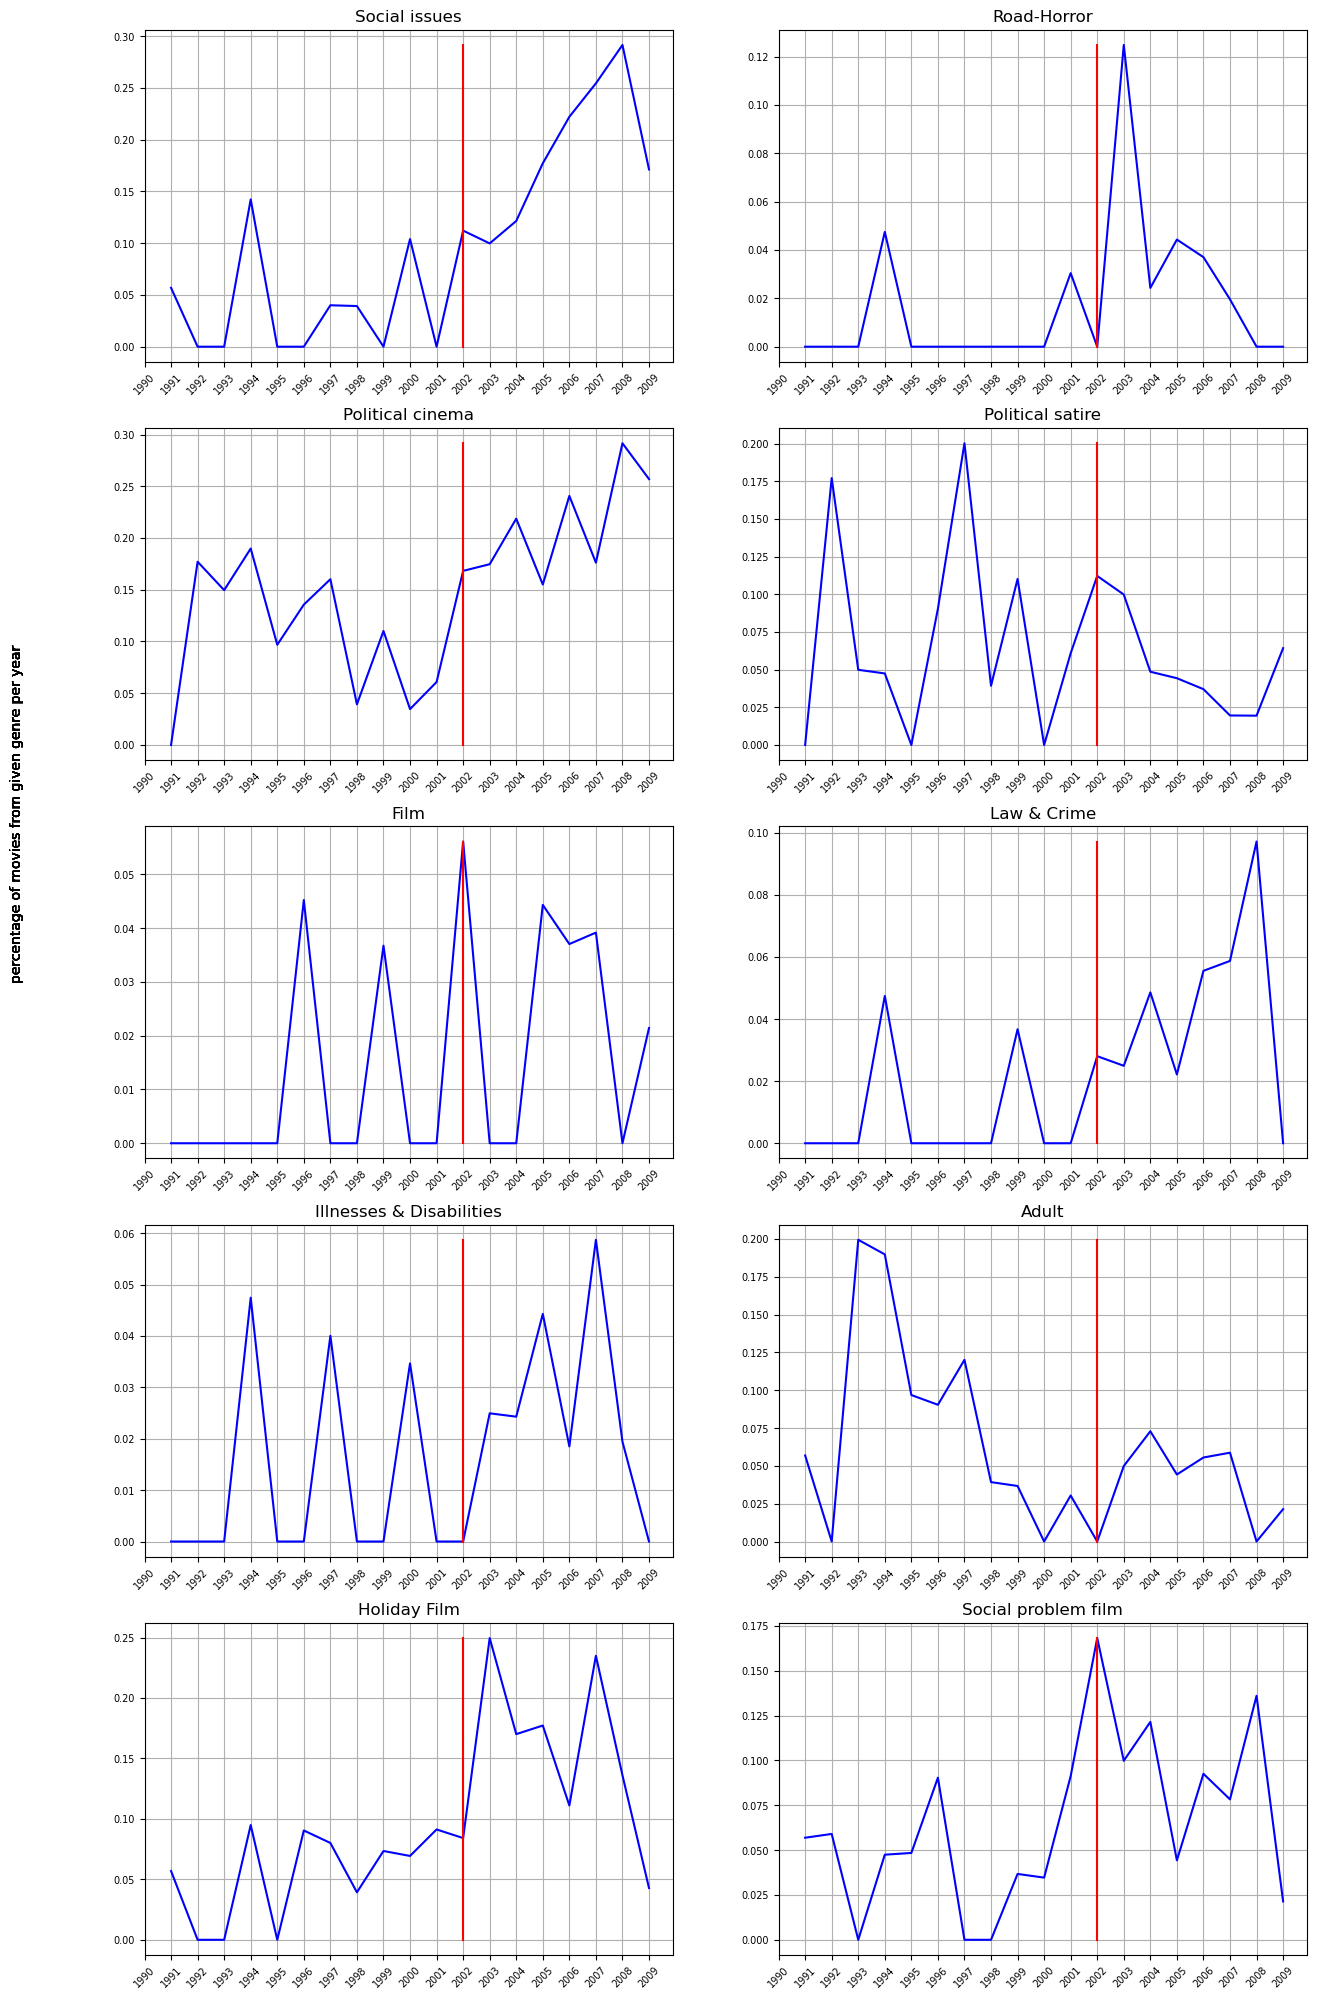

In [18]:
df = get_movies_genre_change(us_movies, genres_unique, 20, 1997,  2002,2006)
plot_percentage_movies_genre_all(us_movies,df.genre.values,1990, 2010, 2002,5,2)